# Get experiments

In [286]:
import pandas as pd

In [287]:
experiments = pd.read_csv('Data/experiments.csv')
print(experiments.keys())
print()
print(experiments['Experiment'].unique())

Index(['Dimension1(nm)', 'Dimension2(nm)', 'OD', 'Dilution(%)',
       'Nano_stock_vol(mL)', 'Diluted_vol(mL)', 'AgConc(M)', 'AgMass(mg)',
       'MeOH_vol(mL)', 'H2O_vol(mL)', 'Doping(%)', 'AgSol(uL)', 'Time(min)',
       'Temperature(C)', 'Experiment'],
      dtype='object')

['1_NPL-4_(5-31-22)' '2_NPL-4_(6-1-22)' '3_NPL-11_(12-26-22)'
 '4_NPL-17_(5-3-23)' '5_NPL-17_(5-22-23)' '6_NPL-6_C.L._(7-7-23)'
 '7_NPL-12_(3-8-23)' '8_NPL-13_(3-8-23)']


# Extend the experiment df with the experiment processed results

In [288]:
import numpy as np 

def _get_peaks(x, y):
    peaks = []
    th = 0.001
    for i in range(1, len(x)-1):
        if y[i] > y[i-1]+th and y[i] > y[i+1]+th:
            peaks.append((x[i], y[i]))
    return peaks

def get_peaks(x, y):
    x = np.array(x)
    p1_i = np.where(x == 450)[0][0]
    p1_e = np.where(x == 550)[0][0]
    p2_i = np.where(x == 550)[0][0]
    p2_e = np.where(x == 700)[0][0]

    x1 = x[p1_i:p1_e]
    y1 = y[p1_i:p1_e]
    x2 = x[p2_i:p2_e]
    y2 = y[p2_i:p2_e]

    return x1[np.argmax(y1)], x2[np.argmax(y2)]

def get_area_under_peaks(x, y, norm=None):
    if not norm:
        return np.trapz(y, x)
    
    x = np.array(x)
    p1_i = np.where(x == 450)[0][0]
    p1_e = np.where(x == 550)[0][0]
    p2_i = np.where(x == 550)[0][0]
    p2_e = np.where(x == 700)[0][0]

    x1 = x[p1_i:p1_e]
    y1 = y[p1_i:p1_e]
    x2 = x[p2_i:p2_e]
    y2 = y[p2_i:p2_e]

    return np.trapz(y1, x1)/norm, np.trapz(y2, x2)/norm

def process_spectrum(x, y, norm_area):
    peaks = get_peaks(x, y)
    areas = get_area_under_peaks(x, y, norm_area)
    return peaks, areas

In [289]:
def f_(d):
    if d.is_integer():
        return f"{int(d)}"
    else:
        decimal = len(str(d).split('.')[1])
        s = f"{d:.{decimal}f}"
        return s

processed_df = pd.DataFrame()
for exp in experiments['Experiment'].unique():
    exp_df = experiments[experiments['Experiment'] == exp]

    for i, setup in exp_df[['Temperature(C)', 'Doping(%)', 'Time(min)']].iterrows():
        T, d, t = setup
        with open(f"Data/fluorescence_data/{exp}/{int(T)}-{f_(d)}-{int(t)}.txt", 'r') as input:
            lines = input.readlines()
            x = []
            y = []
            for line in lines:
                x.append(float(line.split()[0]))
                y.append(float(line.split()[1]))
            norm_y = [yi/max(y) for yi in y]
            norm_area = get_area_under_peak(x, norm_y)
            peaks, areas = process_spectrum(x, norm_y, norm_area)
            results_df = pd.DataFrame({'Temperature(C)': [T], 
                                        'Doping(%)': [d], 
                                        'Time(min)': [t], 
                                        'Peak1': [peaks[0]], 
                                        'Peak2': [peaks[1]], 
                                        'Area1': [areas[0]], 
                                        'Area2': [areas[1]],
                                        'Distance_peaks': [peaks[1]-peaks[0]],
                                        'Wavelengths': [x],
                                        'Fluorescence': [y],
                                        'Fluorescence_norm': [norm_y],}) # we can add other labels here
            new_entry = exp_df.merge(results_df, how='inner', on=['Temperature(C)', 'Doping(%)', 'Time(min)'])
        processed_df = pd.concat([processed_df, new_entry], ignore_index=True)
processed_df.to_csv('Data/processed_data.csv', index=False)

In [311]:
asd = pd.read_csv('Data/processed_data.csv')
sample = asd.iloc[0]
w = [float(a) for a in sample['Wavelengths'][1:-1].split(',')]
i = [float(a) for a in sample['Fluorescence_norm'][1:-1].split(',')]

plt.plot(w, i, color="C0")

Index(['Dimension1(nm)', 'Dimension2(nm)', 'OD', 'Dilution(%)',
       'Nano_stock_vol(mL)', 'Diluted_vol(mL)', 'AgConc(M)', 'AgMass(mg)',
       'MeOH_vol(mL)', 'H2O_vol(mL)', 'Doping(%)', 'AgSol(uL)', 'Time(min)',
       'Temperature(C)', 'Experiment', 'Peak1', 'Peak2', 'Area1', 'Area2',
       'Distance_peaks', 'Wavelengths', 'Fluorescence', 'Fluorescence_norm'],
      dtype='object')


# Entire espectra

In [309]:
original_columns = ['Dimension1(nm)',
                    'Dimension2(nm)',
                    'OD',
                    'Dilution(%)',
                    'Nano_stock_vol(mL)',
                    'Diluted_vol(mL)',
                    'AgConc(M)',
                    'AgMass(mg)',
                    'MeOH_vol(mL)',
                    'H2O_vol(mL)',
                    'Doping(%)',
                    'AgSol(uL)',
                    'Time(min)',
                    'Temperature(C)',
                    'Experiment'
                ]

new_columns = ['Wavelength(nm)', 'Fluorescence', 'Fluorescence_norm']

with open('Data/spectra_data.csv', 'w') as output:
    output.write(','.join(original_columns + new_columns) + '\n')
    for exp in experiments['Experiment'].unique():
        exp_df = experiments[experiments['Experiment'] == exp]

        for i, setup in exp_df[['Temperature(C)', 'Doping(%)', 'Time(min)']].iterrows():
            T, d, t = setup
            props = exp_df[(exp_df['Doping(%)'] == d) & (exp_df['Time(min)'] == t) & (exp_df['Temperature(C)'] == T)].iloc[0].to_list()
            with open(f"Data/fluorescence_data/{exp}/{int(T)}-{f_(d)}-{int(t)}.txt", 'r') as input:
                lines = input.readlines()
                x = []
                y = []
                for line in lines:
                    x.append(float(line.split()[0]))
                    y.append(float(line.split()[1]))
                norm_y = [yi/max(y) for yi in y]
                for xi, yi, norm_yi in zip(x, y, norm_y):
                    new_line = props + [xi, yi, norm_yi]
                    output.write(','.join([str(p) for p in new_line]) + '\n')


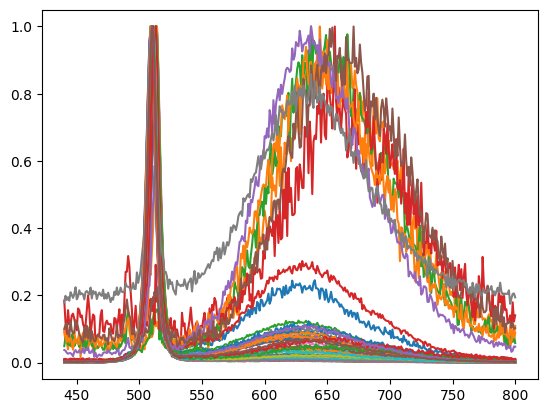

In [310]:
asd = pd.read_csv('Data/spectra_data.csv')

for group, df in asd.groupby(['Experiment', 'Temperature(C)', 'Doping(%)', 'Time(min)']):
    plt.plot(df['Wavelength(nm)'], df['Fluorescence_norm'], label=group[0])
    # plt.legend()
    # break
